In [1]:
import os
import sys
import math
import pickle
import numpy as np

from pathlib import Path
sys.path.insert(1, os.path.join(sys.path[0], '..'))

# For plotting
%matplotlib widget
import matplotlib.pyplot as plt

# Magic IPython deepreloading...
%reload_ext autoreload
%autoreload 2
import builtins
from IPython.lib import deepreload
builtins.reload = deepreload.reload

%autoreload

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"


In [2]:
def transform_contexts(contexts):
    contexts[:,0] = contexts[:,0]*0.4-0.2
    contexts[:,1] = contexts[:,1]*0.4-0.2
    contexts[:,2] = contexts[:,2]*0.1
    return contexts

In [3]:
def load_context_traces(base_dir, seeds, iterations):
    all_context_traces = {}
    all_disc_rew = {}
    all_disc_cost = {}
    max_iter = 0
    for iteration in iterations:
        # iter_context_traces = None
        iter_context_traces = {}
        iter_disc_rew = {}
        iter_disc_cost = {}
        for seed in seeds:
            perf_file = os.path.join(base_dir, f"seed-{seed}", f"iteration-{iteration}", "context_trace.pkl")
            if os.path.exists(perf_file):
                max_iter = max(max_iter, iteration)
                with open(perf_file, "rb") as f:
                    rew, disc_rew, cost, disc_cost, succ, step_len, context_trace = pickle.load(f)
                    iter_context_traces[seed] = transform_contexts(np.array(context_trace))
                    iter_disc_rew[seed] = np.array(disc_rew)
                    iter_disc_cost[seed] = np.array(disc_cost)
        if iter_context_traces is not None:
            all_context_traces[iteration] = iter_context_traces
            all_disc_rew[iteration] = iter_disc_rew
            all_disc_cost[iteration] = iter_disc_cost
    return all_context_traces, all_disc_rew, all_disc_cost, max_iter

In [4]:
def plot_results(base_log_dir, num_updates_per_iteration, iters_to_plot, seeds, env, setting, algorithms, color_type):
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
    plt.rcParams['font.size'] = setting["fontsize"]

    context_dim = setting["context_dim"]
    num_iters = setting["num_iters"]
    steps_per_iter = setting["steps_per_iter"]
    fontsize = setting["fontsize"]
    figsize = setting["figsize"]
    bbox_to_anchor = setting["bbox_to_anchor"]
    subplot_settings = setting["subplot_settings"]
    return_bounds = setting["return_bounds"]
    cost_bounds = setting["cost_bounds"]
    iterations = np.arange(num_updates_per_iteration, num_iters, num_updates_per_iteration, dtype=int)
    final_iterations_step = iterations*steps_per_iter

    fig, axes = plt.subplots(len(algorithms)*len(seeds), len(iters_to_plot), 
                                figsize=figsize,
                             constrained_layout=True, subplot_kw={'projection': '3d'})
    print(axes.shape)
    # axes = np.array(axes).reshape(context_dim, len(seeds))

    x_axis_splitter = np.arange(0.0, 4.0, 4/len(algorithms))*steps_per_iter
    for cur_algo_i, cur_algo in enumerate(algorithms):
        iterations_step = iterations*steps_per_iter

        algorithm = algorithms[cur_algo]["algorithm"]
        label = algorithms[cur_algo]["label"]
        model = algorithms[cur_algo]["model"]
        color = algorithms[cur_algo]["color"]
        cmap = algorithms[cur_algo]["cmap"]
        print(algorithm)

        base_dir = os.path.join(base_log_dir, env, algorithm, model)
        print(base_dir)
        context_traces, disc_rew, disc_cost, max_iter = load_context_traces(
            base_dir=base_dir,
            seeds=seeds,
            iterations=iterations,
        )
        iterations_step = iterations_step[:(max_iter//num_updates_per_iteration+1)]

        if len(context_traces) == 0: continue

        for key in context_traces:
            if key not in iters_to_plot: continue
            for seed_i in range(len(seeds)):
                seed = seeds[seed_i]
                if seed not in context_traces[key]: continue
                idx = int(key/num_updates_per_iteration)
                ax_x = cur_algo_i*len(seeds) + seed_i
                ax_y = np.where(key == iters_to_plot)[0][0] 
                c = disc_rew[key][seed] if color_type == "return" else -disc_cost[key][seed]
                vmin = return_bounds[0] if color_type == "return" else -cost_bounds[1]
                vmax = return_bounds[1] if color_type == "return" else -cost_bounds[0]
                axes[ax_x, ax_y].scatter(
                    context_traces[key][seed][:,0],
                    context_traces[key][seed][:,1],
                    context_traces[key][seed][:,2],
                    c=c, alpha=0.5, s=1.0,
                    cmap=cmap, vmin=vmin, vmax=vmax)
                axes[ax_x, ax_y].set_title(f"{label}, s={seed}, i={iters_to_plot[ax_y]}")
                axes[ax_x, ax_y].grid(True)
                axes[ax_x, ax_y].set_xlim(subplot_settings[0]["lim"])
                axes[ax_x, ax_y].set_ylim(subplot_settings[1]["lim"])
                axes[ax_x, ax_y].set_zlim(subplot_settings[2]["lim"])
                axes[ax_x, ax_y].set_xlabel(subplot_settings[0]["label"])
                axes[ax_x, ax_y].set_ylabel(subplot_settings[1]["label"])
                axes[ax_x, ax_y].set_zlabel(subplot_settings[2]["label"])

    plt.show()

(9, 5)
constrained_wasserstein
/home/ck28372/safe-curriculum/logs/safety_push_3d/constrained_wasserstein/PPOLag_DELTA_CS=0.0_ATP=1.0_CAS=10_DELTA=0.6_DELTA_CT=1.0_METRIC_EPS=0.1_PP=True_PS=True_RAS=10
wasserstein
/home/ck28372/safe-curriculum/logs/safety_push_3d/wasserstein/PPOLag_DELTA_CS=0.0_DELTA=0.6_METRIC_EPS=0.1_PEN_COEFT=0.0
wasserstein
/home/ck28372/safe-curriculum/logs/safety_push_3d/wasserstein/PPOLag_DELTA_CS=0.0_DELTA=0.6_METRIC_EPS=0.1_PEN_COEFT=1.0


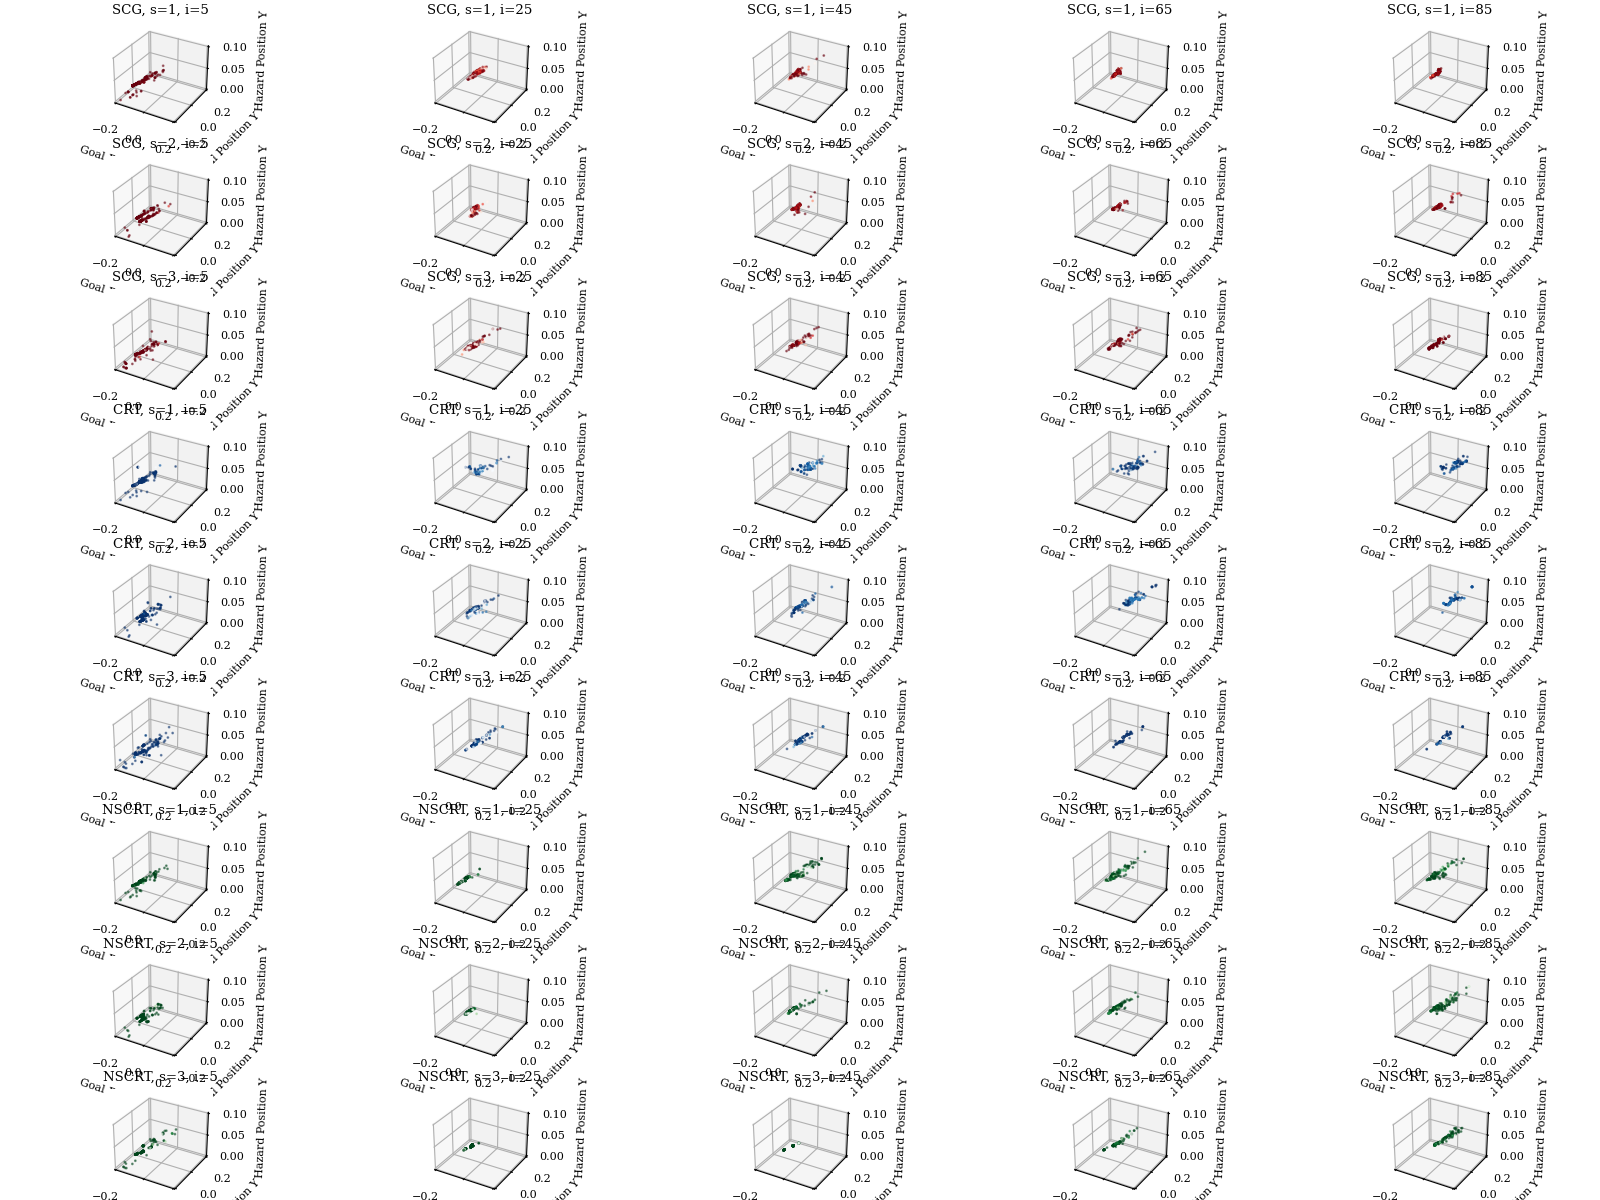

In [5]:
base_log_dir = os.path.join(Path(os.getcwd()).parent, "logs")
num_updates_per_iteration = 5
seeds = [str(i) for i in range(1, 4)]
env = "safety_push_3d"
iter_to_plot = list(range(5, 145, 25))

# color_type = "return"
color_type = "cost"

algorithms = {
    "safety_reach_3d": {
        "SCG": {
            "algorithm": "constrained_wasserstein",
            "label": "SCG",
            "model": "PPOLag_DELTA_CS=0.0_ATP=1.0_CAS=10_DELTA=0.6_DELTA_CT=1.0_METRIC_EPS=0.1_PP=True_PS=True_RAS=10",
            "color": "red",
            "cmap": "Reds",
        },
    },
        "safety_push_3d": {
            "SCG": {
                "algorithm": "constrained_wasserstein",
                "label": "SCG",
                "model": "PPOLag_DELTA_CS=0.0_ATP=1.0_CAS=10_DELTA=0.6_DELTA_CT=1.0_METRIC_EPS=0.1_PP=True_PS=True_RAS=10",
                "color": "red",
                "cmap": "Reds",
            },
            "CRT": {
                "algorithm": "wasserstein",
                "label": "CRT",
                "model": "PPOLag_DELTA_CS=0.0_DELTA=0.6_METRIC_EPS=0.1_PEN_COEFT=0.0",
                "color": "blue",
                "cmap": "Blues",
            },  
            "NSCRT": {
                "algorithm": "wasserstein",
                "label": "NSCRT",
                "model": "PPOLag_DELTA_CS=0.0_DELTA=0.6_METRIC_EPS=0.1_PEN_COEFT=1.0",
                "color": "green",
                "cmap": "Greens",
            },
        },
}

settings = {
    "safety_reach_3d": {
        "context_dim": 3,
        "num_iters": 150,
        "steps_per_iter": 10000,
        "fontsize": 8,
        "figsize": (16, 12),
        "bbox_to_anchor": (.5, 1.05),
        "subplot_settings": {
            0: {
                "label": 'Goal Position X',
                "lim": [-.2, .2],
            },
            1: {
                "label": 'Goal Position Y',
                "lim": [-.2, .2],
            },
            2: {
                "label": 'Hazard Position Y',
                "lim": [0, .1],
            },
        },
        "return_bounds": [25., 70.],
        "cost_bounds": [0., 10.],
    },
    "safety_push_3d": {
        "context_dim": 3,
        "num_iters": 150,
        "steps_per_iter": 10000,
        "fontsize": 8,
        "figsize": (16, 12),
        "bbox_to_anchor": (.5, 1.05),
        "subplot_settings": {
            0: {
                "label": 'Goal Position X',
                "lim": [-.2, .2],
            },
            1: {
                "label": 'Goal Position Y',
                "lim": [-.2, .2],
            },
            2: {
                "label": 'Hazard Position Y',
                "lim": [0, .1],
            },
        },
        "return_bounds": [25., 70.],
        "cost_bounds": [0., 10.],
    },
}

plot_results(
    base_log_dir=base_log_dir,
    num_updates_per_iteration=num_updates_per_iteration,
    seeds=seeds,
    env=env,
    setting=settings[env],
    algorithms=algorithms[env],
    iters_to_plot=iter_to_plot,
    color_type=color_type,
    )